# S1. Visual differences between cohorts
16 March 2020

The two different cohorts have a lot of variability between them, and even within cohorts. This notebook focuses on displaying this differences in various ways. 

In [1]:
%load_ext autoreload
%autoreload 2

saving mosaic to /mnt/Data/figures/emory_mosaic.png


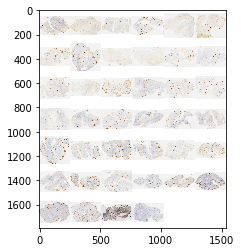

In [15]:
import sys
sys.path.append('../modules/')

from vips_utils import array_vips
import matplotlib.pyplot as plt
from os.path import join
from glob import glob
import numpy as np
import pyvips
from math import ceil
from PIL import Image
from imageio import imwrite


# static variable
DATA_ROOT = '/mnt/Data/'
WSI_DIR_NAMES = ['Dataset_1a_Development_train', 'Dataset_1b_Development_validation', 'Dataset_2_Hold-out',
                 'Dataset_3_CERAD-like_hold-out', 'Dataset_Emory_CERAD-like_hold-out_rescan']
WSI_FILEPATHS = []
for wsi_dir in WSI_DIR_NAMES:
    WSI_FILEPATHS.append([filepath for filepath in sorted(glob(join(DATA_ROOT, 'wsi', wsi_dir, '*.svs')))]) 
WSI_FILEPATHS[2].extend(WSI_FILEPATHS[3])


def make_square(im, side_length=256, fill_color=(255, 255, 255)):
    # resize a numpy image keep in aspect ratio, fill with white pixels
    y, x = im.shape[:2]
    size = max(side_length, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(Image.fromarray(im), (int((size - x) / 2), int((size - y) / 2)))
    new_im = new_im.resize((side_length, side_length))
    return np.array(new_im)


def image_mosaics(filepaths, n_cols=6, side_length=256, save_path=None):
    """For the wsi directories in project build a mosaic of the wsi at low resolution. The images are saved as
    square images while keeping aspect ratio.
    
    Parameters
    ----------
    filepaths : list
        list of files to use to generate mosasics
    n_cols : int (optional)
        number of images in each row, will determine how many rows the mosaic will have
    im_size : tuple (optional)
        size of each image, padded with white to preserve aspect ratio   
    save_path : str (optional)
        give dir and filename to save image to
        
    """
    # saving n_cols images across, get the number of rows needed
    n_rows = ceil(len(filepaths) / n_cols)

    if n_rows == 1:
        _n_cols = len(filepaths)
    else:
        _n_cols = n_cols

    # create the mosaic array, initiated as all zeros
    mosaic = np.full((side_length * n_rows, side_length * _n_cols, 3), [255, 255, 255], dtype=np.uint8)

    for i, filepath in enumerate(filepaths):
        # use pyvips to read wsi at low resolution
        vips_im = pyvips.Image.new_from_file(filepath, level=2) 

        # convert pyvips to numpy
        lr_im = array_vips(vips_im)[:, :, :3]

        # resize the numpy image
        lr_im_resized = make_square(lr_im, side_length=side_length)

        # insert image into mosaic
        mosaic[
            int(i / _n_cols) * side_length:int(i / _n_cols) * side_length + side_length,
            (i % _n_cols) * side_length:(i % _n_cols) * side_length + side_length, :] = lr_im_resized

    # save the mosaic
    if save_path is not None:
        print(f'saving mosaic to {save_path}')
        imwrite(save_path, mosaic)
    
    return mosaic


# im = image_mosaics(WSI_FILEPATHS[0], save_path=join(DATA_ROOT, 'figures/train_mosaic.png'))
# im = image_mosaics(WSI_FILEPATHS[2], save_path=join(DATA_ROOT, 'figures/tang_test_mosaic.png'))
im = image_mosaics(WSI_FILEPATHS[-1], save_path=join(DATA_ROOT, 'figures/emory_mosaic.png'))
plt.imshow(im)
plt.show()